In [ ]:
#importing some modules

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
#other modules have been imported later on as and when required

In [ ]:
#Task 1: Data Collection

#taking user input

ticker_symbol=input('Enter the stock name(e.g., "AAPL" for Apple, "GOOGL" for Alphabet Inc.):')
start_date=input('Enter start date for the data in YYYY-MM-DD format:')
end_date=input('Enter end date for the data in YYYY-MM-DD format:')
time_frame=input('Enter time frame eg: 1d, 1wk, 1mo:')

#retrieving the data
ticker=yf.Ticker(ticker_symbol)

#downloading the data
data_set=ticker.history(start=start_date, end=end_date, interval=time_frame)

#converting the data set into a pandas data frame
df=pd.DataFrame(data_set)

Enter the stock name(e.g., "AAPL" for Apple, "GOOGL" for Alphabet Inc.):AAPL
Enter start date for the data in YYYY-MM-DD format:2012-01-01
Enter end date for the data in YYYY-MM-DD format:2022-01-01
Enter time frame eg: 1d, 1wk, 1mo:1d


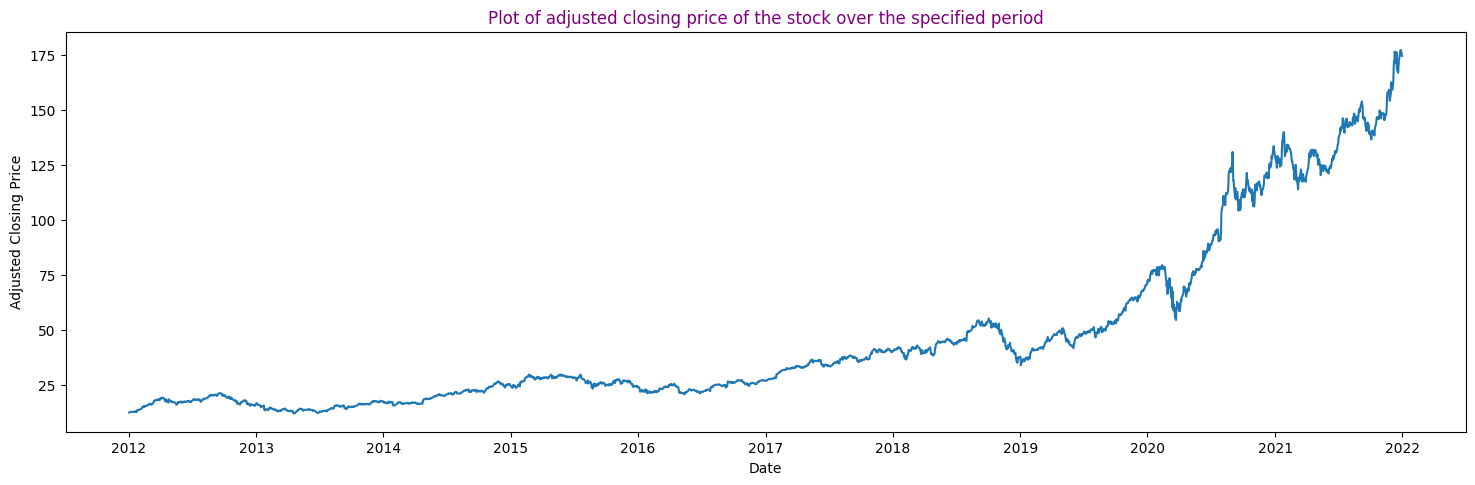

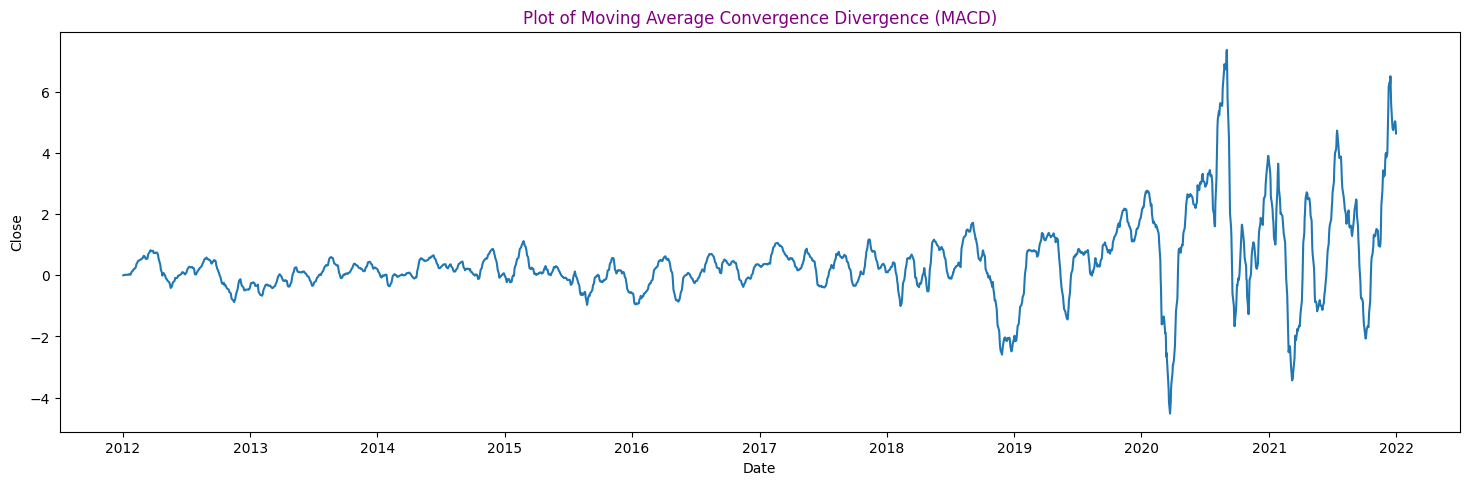

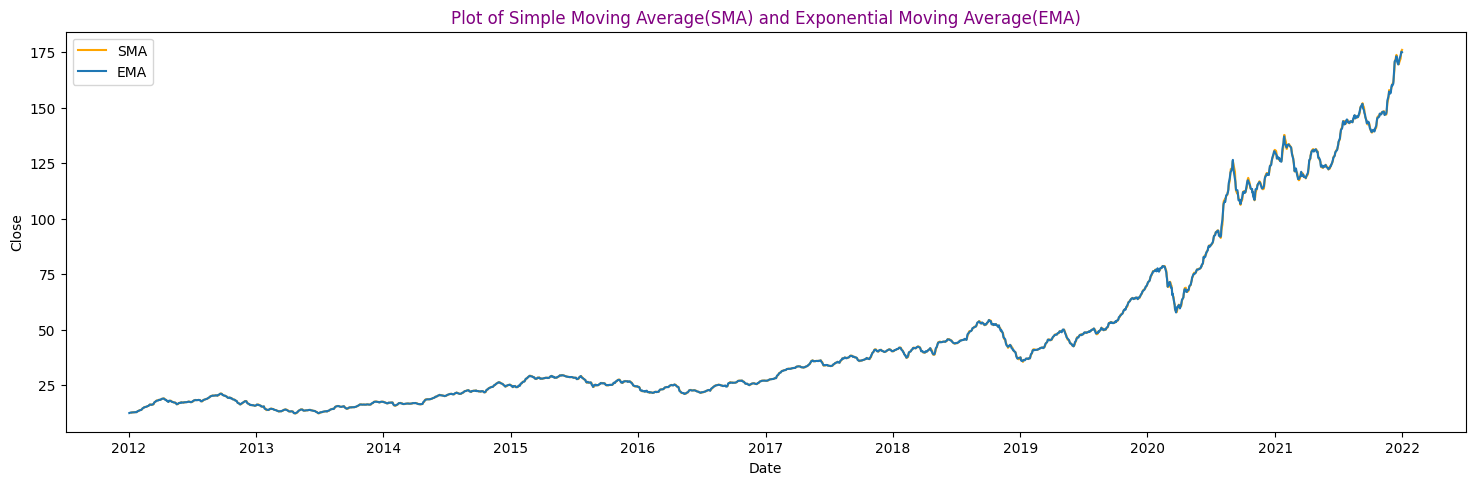

In [ ]:
#Task 2: Data Visualization

#plotting the adjusted closing price of the stock over time

fig1=plt.figure(figsize=(14,4))
axes1=fig1.add_axes([0,0,1,1])
axes1.plot(df.index,df['Close'])
axes1.set_xlabel('Date')
axes1.set_ylabel('Adjusted Closing Price')
axes1.set_title('Plot of adjusted closing price of the stock over the specified period',color='purple')
plt.show()

#plotting Moving Average Convergence Divergence (MACD) and Simple/Exponential Moving Averages (SMA/EMA)

#plotting MACD first

fig2=plt.figure(figsize=(14,4))
axes2=fig2.add_axes([0,0,1,1])

#calculating short term exponential moving average using exponential weighted function ewm() and setting span as 12 periods for s_ema
s_ema=df['Close'].ewm(span=12).mean()

#calculating long term exponential moving average using exponential weighted function ewm() and setting span as 26 periods for l_ema
l_ema=df['Close'].ewm(span=26).mean()

#applying the formula for MACD and adding the corresponding MACD values into a separate column in the dataframe
df['MACD']=s_ema - l_ema

axes2.plot(df.index,df['MACD'])
axes2.set_xlabel('Date')
axes2.set_ylabel('Close')
axes2.set_title('Plot of Moving Average Convergence Divergence (MACD)',color='purple')
plt.show()

#now, plotting SMA & EMA
fig3=plt.figure(figsize=(14,4))
axes3=fig3.add_axes([0,0,1,1])

df['SMA']=df['Close'].rolling(window=5).mean() #calculating and adding the SMA to the dataframe
df['EMA']=df['Close'].ewm(span=5).mean() #calculating and adding the EMA to the dataframe

axes3.plot(df.index,df['SMA'],label='SMA',color='orange')
axes3.plot(df.index,df['EMA'],label='EMA')
axes3.set_xlabel('Date')
axes3.set_ylabel('Close')
axes3.set_title('Plot of Simple Moving Average(SMA) and Exponential Moving Average(EMA)',color='purple')
plt.legend()

In [ ]:
#Task 3: Data Preprocessing

#normalising the data by min-max scaling/standardization

from sklearn.preprocessing import MinMaxScaler

#intialise scaler
scaler=MinMaxScaler(feature_range=(0, 1))
#scaling
scaled_data=scaler.fit_transform(df)
#convert back to dataframe
scaled_df=pd.DataFrame(scaled_data,columns=df.columns)


#creating sliding windows (overlapping subsets) to use as input for the LSTM model

#function to create overlapping sequences
def create_sliding_windows(data,window_size):
  x,y=[],[]
  for i in range(len(data)-window_size):
    x.append(data[i:i+window_size])       #creating overlappping sequences
    y.append(data[i+window_size])           #target variable (the next close price after the sequence)
  return np.array(x), np.array(y)

window_size=40
#converting the data frame into a numpy array
scaled_data_array = scaled_df['Close'].values
#creating the sliding windows
x,y=create_sliding_windows(scaled_data_array,window_size)

#reshaping to 3D (num_samples, window_size, features) - correct format to input to LSTM model
#x.shape returns (nrows,ncols)
#x.shape[0] gives nrows and similarly with x.shape[1]
#(samples, time steps, features); features is 1 because we're considering only one feature - the close price
x = x.reshape((x.shape[0], x.shape[1], 1))




In [ ]:
#Task 4: Build the LSTM Model

#splitting the dataset into training and testing datasets
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=101)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

#building the LSTM model
model=Sequential([
    LSTM(50,return_sequences=True,input_shape=[x_train.shape[1],1]), #layer1
    #50 neurons, all sequences are returned and not just the final state since the 2nd layer uses them
    LSTM(50), #layer2
    #here only the last output is passed
    Dense(1)  #output layer - final predicted value
])

#compiling the model
#adam is a commonly used optimizer
#mean squared error taken as loss
model.compile(optimizer='adam',loss='mse')

#train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))
#epoch - number of times the dataset is passed through the model

#loss calculation
loss = model.evaluate(x_test, y_test)


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0226 - val_loss: 2.8407e-04
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 3.5237e-04 - val_loss: 2.5189e-04
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.7729e-04 - val_loss: 2.5022e-04
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 3.1141e-04 - val_loss: 2.3816e-04
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.6444e-04 - val_loss: 2.2747e-04
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.5790e-04 - val_loss: 2.2014e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 2.8924e-04 - val_loss: 2.0284e-04
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 2.4058e-04 - val_loss: 2.5448e-04
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.3978e-04 - val_loss: 2.0981e-04
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.1887e-04 - val_loss: 2.7547e-04
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 2.3553e-04 - 

(40, 1)


Exception ignored in: <function _xla_gc_callback at 0x7d32cfa21090>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


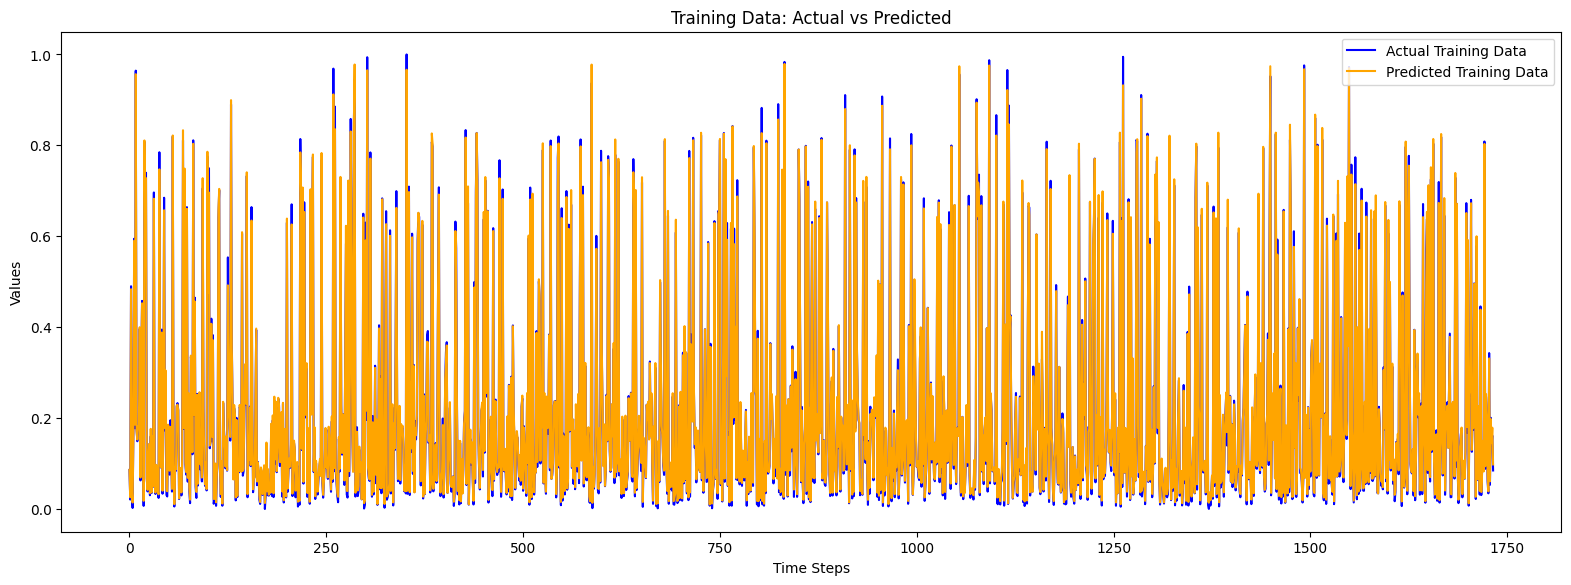

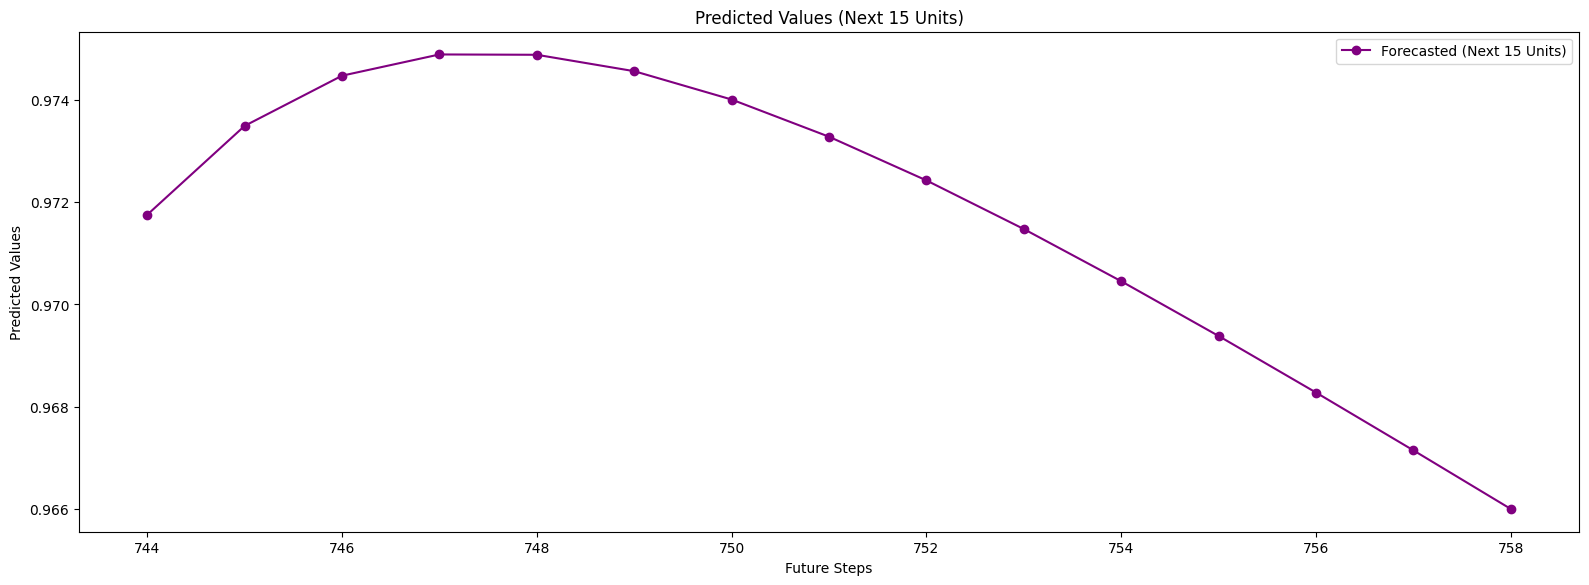

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² Score: 0.9972410475364897


In [ ]:
#Task 5: Prediction and Visualization

#taking the last window from the test data
last_known_window=x_test[-1]
print(last_known_window.shape)

predictions=[]
for i in range(15):
  last_known_window = last_known_window.reshape((1, window_size, 1)) #(samples,time steps, features)
  #making a prediction
  next_value = model.predict(last_known_window)
  #updating the predictions list
  predictions.append(next_value[0,0])
  last_known_window = np.append(last_known_window[:, 1:, :], next_value.reshape(1, 1, 1), axis=1)
                                                # 1:, because we start from the 2nd time step (simulated the sliding window)
#converting list to array
predictions=np.array(predictions)

#visualization

# making predictions on the training dataset to compare with actual values
y_train_predicted = model.predict(x_train)

# Plot the actual vs predicted values
fig4=plt.figure(figsize=(15,5))
axes4=fig4.add_axes([0,0,1,1])
axes4.plot(y_train, label='Actual Training Data', color='blue')
axes4.plot(y_train_predicted, label='Predicted Training Data', color='orange')
axes4.set_title("Training Data: Actual vs Predicted")
axes4.set_xlabel("Time Steps")
axes4.set_ylabel("Values")
plt.legend()
plt.show()

#plotting the predicted close prices for the next 15 units

#creating a range for the next 15 units
future_steps = np.arange(len(y_test), len(y_test) + 15)

fig5=plt.figure(figsize=(15,5))
axes5=fig5.add_axes([0,0,1,1])
axes5.plot(future_steps, predictions, label='Forecasted (Next 15 Units)', color='purple',marker='o')
axes5.set_title("Predicted Values (Next 15 Units)")
axes5.set_xlabel("Future Steps")
axes5.set_ylabel("Predicted Values")
plt.legend()
plt.show()

#calculating R² score

from sklearn.metrics import r2_score
#predict on the test set
y_test_predicted = model.predict(x_test)

#calculating R² score
r2 = r2_score(y_test, y_test_predicted)
print("R² Score:",r2)